In [101]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import t
from scipy import interp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

plt.style.use('ggplot')

# EDA

In [135]:
data = pd.read_pickle('../data/processed/feature_encoded_merged_data.pkl')
test_data = pd.read_pickle('../data/model_results.pkl')
unigrams = pd.read_csv('../data/model_unigrams.csv')
phrases = pd.read_csv('../data/financial_phrases.txt', sep = '\t', header = None).head(2107)
simulation = pd.read_csv('../data/return.csv')

In [136]:
def select_phrases(phrases):
    return phrases[:2107]

In [137]:
data['top_phrases'] = data['phrase_vec'].apply(select_phrases)

In [138]:
data.head()

,date,time,event_type,cleaned_event,full_text,symbol,Surprise(%),Reported EPS,Consensus EPS,hr,...,price_change_30,price_change_90,price_change_365,targe_price_change,prev_vix_values,dataset,target,unigram_vec,phrase_vec,top_phrases
0,2004-07-20,143800,EVENTS:\t\tFinancial statements and exhibits\n,[financial statements and exhibits],\n<DOCUMENT>\nFILE:FULT/FULT-8K-20040720143800...,FULT,-3.13,0.31,0.32,14.38,...,2.57,3.01,8.21,0.414034,14.17,train,STAY,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2004-10-19,174320,EVENTS:\tResults of Operations and Financial C...,[results of operations and financial condition...,\n<DOCUMENT>\nFILE:FULT/FULT-8K-20041019174320...,FULT,0.00,0.32,0.32,17.43,...,0.39,7.58,14.93,-1.208981,15.13,train,DOWN,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2005-01-18,123338,EVENTS:\tResults of Operations and Financial C...,[results of operations and financial condition...,\n<DOCUMENT>\nFILE:FULT/FULT-8K-20050118123338...,FULT,0.00,0.33,0.33,12.33,...,0.61,5.15,13.60,-0.250990,12.47,train,STAY,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2005-04-13,140932,EVENTS:\tResults of Operations and Financial C...,[results of operations and financial condition...,\n<DOCUMENT>\nFILE:FULT/FULT-8K-20050413140932...,FULT,0.00,0.33,0.33,14.09,...,-2.19,-1.37,8.56,0.070178,13.31,train,STAY,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2005-07-19,132220,EVENTS:\tResults of Operations and Financial C...,[results of operations and financial condition...,\n<DOCUMENT>\nFILE:FULT/FULT-8K-20050719132220...,FULT,0.00,0.27,0.27,13.22,...,2.88,11.54,17.17,0.604141,10.45,train,STAY,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [139]:
train = data.loc[data['dataset'] == 'train'].copy()
val = data.loc[data['dataset'] == 'val'].copy()
test = data.loc[data['dataset'] == 'test'].copy()

### Event Breakdown

In [8]:
mlb = MultiLabelBinarizer()

all_events = pd.DataFrame(mlb.fit_transform(data['cleaned_event']),
                   columns = mlb.classes_,
                   index = data['cleaned_event'].index)

In [134]:
events = data.explode('cleaned_event').groupby('cleaned_event').count()['symbol']
events = events.reset_index().sort_values(by = ['symbol'], ascending = False).reset_index(drop = True)
events = events.rename(columns = {'cleaned_event': 'event', 'symbol': 'count'})
events.head(10)

,event,count
0,financial statements and exhibits,32071
1,results of operations and financial condition,31271
2,regulation fd disclosure,4994
3,other events,2305
4,election of directors,923
5,entry into a material definitive agreement,550
6,appointment of certain officers: compensatory ...,528
7,departure of directors or certain officers,528
8,appointment of principal officers,395
9,departure of directors or principal officers,395


### Class Breakdown

In [10]:
pd.DataFrame(data = [data.groupby(data['target']).count()['symbol'] / data.shape[0],
                     train.groupby(train['target']).count()['symbol'] / train.shape[0],
                     val.groupby(val['target']).count()['symbol'] / val.shape[0],
                     test.groupby(test['target']).count()['symbol'] / test.shape[0]],
             index = ["all_data", "train", "val", "test"]
            )

target,DOWN,STAY,UP
all_data,0.381330,0.216474,0.402195
train,0.372236,0.213762,0.414003
val,0.392472,0.215515,0.392013
test,0.388398,0.222859,0.388742


In [11]:
pd.DataFrame(data = [data.groupby(data['target']).mean()['targe_price_change'],
                     train.groupby(train['target']).mean()['targe_price_change'],
                     val.groupby(val['target']).mean()['targe_price_change'],
                     test.groupby(test['target']).mean()['targe_price_change']],
             index = ["all_data", "train", "val", "test"]
            )

target,DOWN,STAY,UP
all_data,-5.416298,-0.032407,5.942713
train,-5.692446,-0.038576,6.178306
val,-4.850204,-0.033597,5.717755
test,-5.458181,-0.019418,5.667296


### Example Phrases + Unigrams

In [150]:
uni_percent = [np.array(vector) for vector in train['unigram_vec'].values]
uni_percent = np.array(uni_percent).sum(axis = 0) / len(train)

phrase_percent = [np.array(vector) for vector in train['top_phrases'].values]
phrase_percent = np.array(phrase_percent).sum(axis = 0) / len(train)

In [163]:
unigrams["% of 8-K's"] = uni_percent
unigrams.head(10)

,unigrams,% of 8-K's
0,hanover,0.001833
1,repo,0.988599
2,wellcare,0.001089
3,epr,0.640140
4,heco,0.005557
5,meyer,0.005500
6,crowe,0.003266
7,asb,0.056434
8,eurocurrency,0.001318
9,abn,0.007563


In [162]:
phrases["% of 8-K's"] = phrase_percent
phrases = phrases.rename(columns = {1: 'phrases'})
phrases[['phrases', "% of 8-K's"]].sort_values(by = "% of 8-K's", ascending = False).reset_index(drop = True).head(10)

,phrases,% of 8-K's
0,press release,0.887533
1,cash flow,0.511459
2,fourth quarter,0.505615
3,annual report,0.421909
4,income tax,0.382835
5,accounting principle,0.378022
6,accounting principles,0.364386
7,financial measures,0.343703
8,risk factor,0.314942
9,tax rate,0.289618


# Result Analysis

### ROC

In [13]:
def compute_micro_average(all_data, train, test, **kwargs):

    num_train = train[['Surprise(%)', 'price_change_7', 
              'price_change_30', 'price_change_90', 'price_change_365',
              'prev_vix_values']].to_numpy()
    num_test = test[['Surprise(%)', 'price_change_7', 
              'price_change_30', 'price_change_90', 'price_change_365',
              'prev_vix_values']].to_numpy()
    
    scaler = StandardScaler()
    scaler.fit(num_train)
    num_train = scaler.transform(num_train)
    num_test = scaler.transform(num_test)
    
    mlb = MultiLabelBinarizer()

    all_events = pd.DataFrame(mlb.fit_transform(all_data['cleaned_event']),
                              columns = mlb.classes_,
                              index = all_data['cleaned_event'].index)
    
    train_events = all_events.iloc[all_data.loc[all_data['dataset'] == 'train'].index].to_numpy()
    test_events = all_events.iloc[all_data.loc[all_data['dataset'] == 'test'].index].to_numpy()
    
    train_y = train[['target']].to_numpy().ravel()
    test_y = test[['target']].to_numpy().ravel()
    
    train_y = label_binarize(train_y, classes=['UP', 'STAY', 'DOWN'])
    test_y = label_binarize(test_y, classes=['UP', 'STAY', 'DOWN'])
    n_classes = train_y.shape[1]
    
    if kwargs['train_type'] == 'unigram':
        train_unigrams = np.array(train['unigram_vec'].values.tolist())
        test_unigrams = np.array(test['unigram_vec'].values.tolist())

        train_X = np.concatenate((train_events, num_train, train_unigrams), axis = 1)
        test_X = np.concatenate((test_events, num_test, test_unigrams), axis = 1)
        
        model = OneVsRestClassifier(RandomForestClassifier(max_depth = 10, n_estimators = 2000, max_features = 1250))
        model = model.fit(train_X, train_y)
        
    if kwargs['train_type'] == 'phrase':
        train_phrases = np.array(train['top_phrases'].values.tolist())
        test_phrases = np.array(test['top_phrases'].values.tolist())
        
        train_X = np.concatenate((train_events, num_train, train_phrases), axis = 1)
        test_X = np.concatenate((test_events, num_test, test_phrases), axis = 1)
        
        model = OneVsRestClassifier(RandomForestClassifier(max_depth = 10, n_estimators = 2000, max_features = 1250))
        model = model.fit(train_X, train_y)
    
    if kwargs['train_type'] == 'base':
        train_X = np.concatenate((train_events, num_train), axis = 1)
        test_X = np.concatenate((test_events, num_test), axis = 1)
        
        model = OneVsRestClassifier(RandomForestClassifier(max_depth = 10, n_estimators = 2000))
        model = model.fit(train_X, train_y)

    # Learn to predict each class against the other
    
    score_y = model.predict_proba(test_X)
    
    # Compute ROC curve and ROC area for each class
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], score_y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), score_y.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return fpr, tpr, roc_auc

In [14]:
%%time

fpr_base, tpr_base, roc_base = compute_micro_average(data, train, test, train_type = 'base')

CPU times: user 1min 51s, sys: 2.33 s, total: 1min 54s
Wall time: 1min 57s


In [15]:
%%time

fpr_uni, tpr_uni, roc_uni = compute_micro_average(data, train, test, train_type = 'unigram')

CPU times: user 3h 31min 14s, sys: 1min 2s, total: 3h 32min 16s
Wall time: 3h 33min 46s


In [16]:
%%time

fpr_phrase, tpr_phrase, roc_pharse = compute_micro_average(data, train, test, train_type = 'phrase')

CPU times: user 3h 29min 45s, sys: 43 s, total: 3h 30min 28s
Wall time: 3h 30min 58s


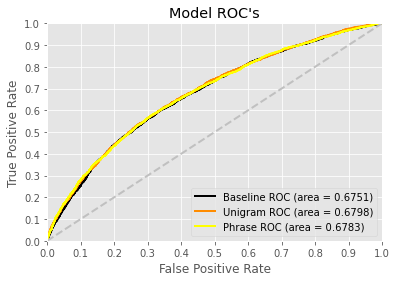

In [117]:
plt.figure()
lw = 2

plt.plot(fpr_base[2], tpr_base[2], color = 'black',
         lw = lw, label = 'Baseline ROC (area = %0.4f)' % roc_base[2])

plt.plot(fpr_uni[2], tpr_uni[2], color = 'darkorange',
         lw = lw, label = 'Unigram ROC (area = %0.4f)' % roc_uni[2])

plt.plot(fpr_phrase[2], tpr_phrase[2], color = 'yellow',
         lw = lw, label = 'Phrase ROC (area = %0.4f)' % roc_pharse[2])

plt.plot([0, 1], [0, 1], color = 'silver', lw = lw, linestyle = '--')

plt.xlim([0.0, 1.0])
plt.xticks(np.arange(0, 1.1, 0.1))

plt.ylim([0.0, 1.0])
plt.yticks(np.arange(0, 1.1, 0.1))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model ROC's")
plt.legend(loc = "lower right")
plt.show()

### Accuracy

In [11]:
print('baseline accuracy: ' + str(sum(test_data['target'] == test_data['base_pred']) / len(test_data['target'])))
print('unigram accuracy: ' + str(sum(test_data['target'] == test_data['unigram_pred']) / len(test_data['target'])))
print('phrase accuracy: ' + str(sum(test_data['target'] == test_data['phrase_pred']) / len(test_data['target'])))

baseline accuracy: 0.5194313882838473
unigram accuracy: 0.525621919064542
phrase accuracy: 0.5261951163590508


In [78]:
up_data = test_data.loc[test_data['phrase_pred'] == 'UP'].copy()
stay_data = test_data.loc[test_data['phrase_pred'] == 'STAY'].copy()
down_data = test_data.loc[test_data['phrase_pred'] == 'DOWN'].copy()

In [83]:
labels = [up_data, stay_data, down_data]
models = ['base_pred', 'unigram_pred', 'phrase_pred']
accuracy = []
for model in models:
    temp = []
    for label in labels:
        temp.append(len(label[label['target'] == label[model]]) / len(label))
    accuracy.append(temp)

In [85]:
pd.DataFrame({'baseline': accuracy[0],
             'unigram': accuracy[1],
             'phrase': accuracy[2]},
            index = ['UP', 'STAY', 'DOWN'] )

,baseline,unigram,phrase
UP,0.516439,0.518889,0.516847
STAY,0.294355,0.431452,0.475806
DOWN,0.539128,0.541364,0.542482


### Significant Unigrams + Phrases

In [33]:
def compute_feature_importance(all_data, train, test, **kwargs):

    num_train = train[['Surprise(%)', 'price_change_7', 
              'price_change_30', 'price_change_90', 'price_change_365',
              'prev_vix_values']].to_numpy()    
    scaler = StandardScaler()
    scaler.fit(num_train)
    num_train = scaler.transform(num_train)
    
    mlb = MultiLabelBinarizer()
    all_events = pd.DataFrame(mlb.fit_transform(all_data['cleaned_event']),
                              columns = mlb.classes_,
                              index = all_data['cleaned_event'].index)   
    train_events = all_events.iloc[all_data.loc[all_data['dataset'] == 'train'].index].to_numpy()
    
    train_y = train[['target']].to_numpy().ravel()
    
    if kwargs['train_type'] == 'unigram':
        train_unigrams = np.array(train['unigram_vec'].values.tolist())
        train_X = np.concatenate((train_events, num_train, train_unigrams), axis = 1)
        
        model = RandomForestClassifier(max_depth = 10, n_estimators = 2000, max_features = 1250)
        model = model.fit(train_X, train_y)
        
    if kwargs['train_type'] == 'phrase':
        train_phrases = np.array(train['top_phrases'].values.tolist())
        train_X = np.concatenate((train_events, num_train, train_phrases), axis = 1)
        
        model = RandomForestClassifier(max_depth = 10, n_estimators = 2000, max_features = 1250)
        model = model.fit(train_X, train_y)
    
    return model.feature_importances_

In [34]:
%%time

uni_importance = compute_feature_importance(data, train, test, train_type = 'unigram')

CPU times: user 1h 2min 47s, sys: 25.2 s, total: 1h 3min 13s
Wall time: 1h 3min 38s


In [35]:
%%time

phrase_importance = compute_feature_importance(data, train, test, train_type = 'phrase')

CPU times: user 1h 2min 1s, sys: 18.4 s, total: 1h 2min 19s
Wall time: 1h 2min 28s


In [63]:
events = np.array(all_events.columns)
numerical = np.array(['Surprise(%)', 'price_change_7', 
              'price_change_30', 'price_change_90', 'price_change_365',
              'prev_vix_values'])

In [69]:
uni_feature_importance = pd.DataFrame({'feature': np.concatenate((events, numerical, unigrams.values.ravel())),
                                       'importance': uni_importance})
uni_feature_importance.sort_values(by = 'importance', ascending = False).head(20).reset_index(drop = True)

,feature,importance
0,Surprise(%),0.227200
1,price_change_365,0.048843
2,prev_vix_values,0.045149
3,price_change_7,0.035074
4,price_change_90,0.031560
5,price_change_30,0.029246
6,semiconductor,0.003361
7,results of operations and financial condition,0.003084
8,federal,0.003028
9,weak,0.002605


In [77]:
phrase_feature_importance = pd.DataFrame({'feature': np.concatenate((events, numerical, phrases[1].values.ravel())),
                                       'importance': phrase_importance})
phrase_feature_importance.sort_values(by = 'importance', ascending = False).head(20).reset_index(drop = True)

,feature,importance
0,Surprise(%),0.283263
1,price_change_365,0.063257
2,prev_vix_values,0.058757
3,price_change_7,0.046266
4,price_change_90,0.040840
5,price_change_30,0.038773
6,results of operations and financial condition,0.004311
7,energy services,0.003334
8,operating margin,0.002923
9,revenue growth,0.002915


### P&L Analysis

In [129]:
simulation.head()

,time,EPS Baseline,Unigram Baseline,AutoPhrase
0,2010-01,1.334318,1.335015,1.433951
1,2010-02,1.735544,1.762196,1.773824
2,2010-03,1.378537,1.362123,1.496369
3,2010-04,1.470432,1.606316,1.621785
4,2010-05,1.595313,1.564794,1.598195


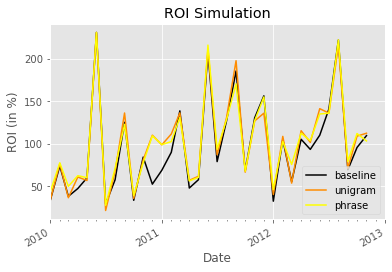

In [130]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

dates = [dt.datetime.strptime(d,'%Y-%m').date() for d in simulation['time'].values]
ROI_baseline = (simulation['EPS Baseline'].values - 1) * 100
ROI_unigram = (simulation['Unigram Baseline'].values - 1) * 100
ROI_phrase = (simulation['AutoPhrase'].values - 1) * 100

fig, ax = plt.subplots()
ax.plot(dates, ROI_baseline, color = 'black', label = 'baseline')
ax.plot(dates, ROI_unigram, color = 'darkorange', label = 'unigram')
ax.plot(dates, ROI_phrase, color = 'yellow', label = 'phrase')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(dates[0], 'Y')
datemax = np.datetime64(dates[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('ROI (in %)')
plt.title("ROI Simulation")
plt.legend(loc = "lower right")

plt.show()